# visualization

## import 

In [242]:
from __future__ import print_function
import sys
from syslog import LOG_MAIL

from urllib3 import Retry
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision
import random
import os
import argparse
import numpy as np
from PreResNet_cifar import *
import dataloader_cifar as dataloader
from math import log2
from Contrastive_loss import *

import collections.abc
from collections.abc import MutableMapping
from flow_trainer import FlowTrainer
from flowModule.utils import standard_normal_logprob
from tqdm import tqdm
model_name_warmup = 'Net_warmup.pth'
model_name_flow_warmup = 'FlowNet_warmup.pth'

model_name = 'Net.pth'
model_name_flow = 'FlowNet.pth'
project_path = './checkpoint/cifar10_sym_0.9_flow_one_net_one_flow_b256_lamb'
isFlow = True
num_samples = 50000


In [243]:
parser = argparse.ArgumentParser(description='PyTorch CIFAR Training')
parser.add_argument('--batch_size', default=64, type=int, help='train batchsize') 
parser.add_argument('--lr', '--learning_rate', default=0.02, type=float, help='initial learning rate')
parser.add_argument('--noise_mode',  default='sym')
parser.add_argument('--alpha', default=4, type=float, help='parameter for Beta')
parser.add_argument('--lambda_u', default=30, type=float, help='weight for unsupervised loss')
parser.add_argument('--lambda_c', default=0.025, type=float, help='weight for contrastive loss')
parser.add_argument('--T', default=0.5, type=float, help='sharpening temperature')
parser.add_argument('--num_epochs', default=350, type=int)
parser.add_argument('--r', default=0.9, type=float, help='noise ratio')
parser.add_argument('--d_u',  default=0.7, type=float)
parser.add_argument('--tau', default=5, type=float, help='filtering coefficient')
parser.add_argument('--metric', type=str, default = 'JSD', help='Comparison Metric')
parser.add_argument('--seed', default=123)
parser.add_argument('--gpuid', default=0, type=int)
parser.add_argument('--resume', default=False, type=bool, help = 'Resume from the warmup checkpoint')
parser.add_argument('--num_class', default=10, type=int)
parser.add_argument('--data_path', default='./data/cifar10', type=str, help='path to dataset')
parser.add_argument('--dataset', default='cifar10', type=str)
parser.add_argument('--flow_modules', default="8-8-8-8", type=str)
parser.add_argument('--name', default="", type=str)
args = parser.parse_args(args=[])

print(args)

Namespace(T=0.5, alpha=4, batch_size=64, d_u=0.7, data_path='./data/cifar10', dataset='cifar10', flow_modules='8-8-8-8', gpuid=0, lambda_c=0.025, lambda_u=30, lr=0.02, metric='JSD', name='', noise_mode='sym', num_class=10, num_epochs=350, r=0.9, resume=False, seed=123, tau=5)


## load model

In [244]:
def create_model():
    model = ResNet18(num_classes=args.num_class)
    model = model.cuda()
    return model
def resume_model(path):
    net_warmup.load_state_dict(torch.load(os.path.join(path, model_name_warmup))['net'])
    net.load_state_dict(torch.load(os.path.join(path, model_name))['net'])
    if isFlow:
        flowNet_warmup.load_state_dict(torch.load(os.path.join(path, model_name_flow_warmup))['net'])
        flowNet.load_state_dict(torch.load(os.path.join(path, model_name_flow))['net'])

In [245]:
# load encoder
net_warmup = create_model()
net = create_model()

# load flow model
if isFlow:
    flowTrainer = FlowTrainer(args)
    flowNet_warmup = flowTrainer.create_model()    
    flowNet = flowTrainer.create_model()    
resume_model(project_path)

Training T : 1.0
Number of trainable parameters of Point CNF: 11313
Training T : 1.0
Number of trainable parameters of Point CNF: 11313


## load data loader

In [246]:
noise_file = '%s/clean_%.4f_%s.npz'%(args.data_path,args.r, args.noise_mode)
## Call the dataloader
loader = dataloader.cifar_dataloader(args.dataset, r=args.r, noise_mode=args.noise_mode,batch_size=args.batch_size,num_workers=4,\
    root_dir=project_path,log="", noise_file=noise_file)
test_loader = loader.run(0, 'test')
eval_loader = loader.run(0, 'eval_train')

In [247]:
noise_file

'./data/cifar10/clean_0.9000_sym.npz'

## test

In [248]:
## Test Accuracy
def test(net1,net2):
    net1.eval()
    net2.eval()

    num_samples = 1000
    correct = 0
    total = 0
    loss_x = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.cuda(), targets.cuda()
            _, outputs1 = net1(inputs)
            _, outputs2 = net2(inputs)           
            outputs = outputs1+outputs2
            _, predicted = torch.max(outputs, 1)            
#             loss = CEloss(outputs, targets)  
#             loss_x += loss.item()

            total += targets.size(0)
            correct += predicted.eq(targets).cpu().sum().item()  

    acc = 100.*correct/total
    return acc

In [249]:
# acc = test(net1,net2)
acc_flow_warmup = flowTrainer.testByFlow(net_warmup, flowNet_warmup, test_loader)
acc_flow = flowTrainer.testByFlow(net, flowNet, test_loader)
print("acc(warmup) ", acc_flow_warmup, ", acc(flow) = ", acc_flow)

acc(warmup)  36.64 , acc(flow) =  70.45


## compare JSD, flow density

In [250]:
# KL divergence
def kl_divergence(p, q):
    return (p * ((p+1e-10) / (q+1e-10)).log()).sum(dim=1)

## Jensen-Shannon Divergence 
class Jensen_Shannon(nn.Module):
    def __init__(self):
        super(Jensen_Shannon,self).__init__()
        pass
    def forward(self, p,q):
        m = (p+q)/2
        return 0.5*kl_divergence(p, m) + 0.5*kl_divergence(q, m)
## Calculate JSD
# def Calculate_JSD(model1, model2, num_samples):  
#     JS_dist = Jensen_Shannon()
#     JSD   = torch.zeros(num_samples)    

#     for batch_idx, (inputs, targets, index) in enumerate(eval_loader):
#         inputs, targets = inputs.cuda(), targets.cuda()
#         batch_size = inputs.size()[0]

#         ## Get outputs of both network
#         with torch.no_grad():
#             out1 = torch.nn.Softmax(dim=1).cuda()(model1(inputs)[1])     
#             out2 = torch.nn.Softmax(dim=1).cuda()(model2(inputs)[1])

#         ## Get the Prediction
#         out = (out1 + out2)/2     

#         ## Divergence clculator to record the diff. between ground truth and output prob. dist.  
#         dist = JS_dist(out,  F.one_hot(targets, num_classes = args.num_class))
#         JSD[int(batch_idx*batch_size):int((batch_idx+1)*batch_size)] = dist

#     return JSD
def Calculate_JSD(net, flowNet, num_samples):  
    JS_dist = Jensen_Shannon()
    JSD   = torch.zeros(num_samples)    

    for batch_idx, (inputs, targets, index) in tqdm(enumerate(eval_loader)):
        inputs, targets = inputs.cuda(), targets.cuda()
        batch_size = inputs.size()[0]

        ## Get outputs of both network
        with torch.no_grad():
            feature = net(inputs)[0]
            out = flowTrainer.predict(flowNet, feature)

        ## Divergence clculator to record the diff. between ground truth and output prob. dist.  
        dist = JS_dist(out,  F.one_hot(targets, num_classes = args.num_class))
        JSD[int(batch_idx*batch_size):int((batch_idx+1)*batch_size)] = dist

    return JSD

In [260]:
prob = Calculate_JSD(net, flowNet, num_samples)
# prob = Calculate_JSD(net_warmup, flowNet_warmup, num_samples)
threshold = torch.mean(prob)
if threshold.item()>args.d_u:
    threshold = threshold - (threshold-torch.min(prob))/arg.tau
SR = torch.sum(prob<threshold).item()/num_samples    

500it [01:20,  6.20it/s]


In [261]:
labeled_trainloader, unlabeled_trainloader = loader.run(SR, 'train', prob= prob) # Uniform Selection

labeled_idx = labeled_trainloader.dataset.pred_idx
unlabeled_idx = unlabeled_trainloader.dataset.pred_idx
class_ind = labeled_trainloader.dataset.class_ind
labeled_prob = [prob[i] for i in labeled_idx]
unlabeled_prob = [prob[i] for i in unlabeled_idx]
sample_ratio = torch.sum(prob<threshold).item()/num_samples

In [262]:
noise_label = np.load(noise_file)['label']
noise_idx = np.load(noise_file)['index']
idx       = list(range(50000))
clean_idx = [x for x in idx if x not in noise_idx]

In [263]:
## True Positive
TP = [x for x in labeled_idx if x in clean_idx]
## False Positive
FP = [x for x in labeled_idx if x in noise_idx]

In [264]:
print("TP :", len(TP), "FP:", len(FP))

TP : 4586 FP: 15704


In [265]:
TP_classes = []
NP_classes = []
for i in range(0, 10):
    TP_classes.append(len([x for x in TP if x in class_ind[i]]))
    NP_classes.append(len([x for x in FP if x in class_ind[i]]))

In [266]:
TP_classes

[470, 494, 384, 492, 475, 349, 475, 442, 505, 500]

In [267]:
NP_classes

[1559, 1535, 1645, 1537, 1554, 1680, 1554, 1587, 1524, 1529]

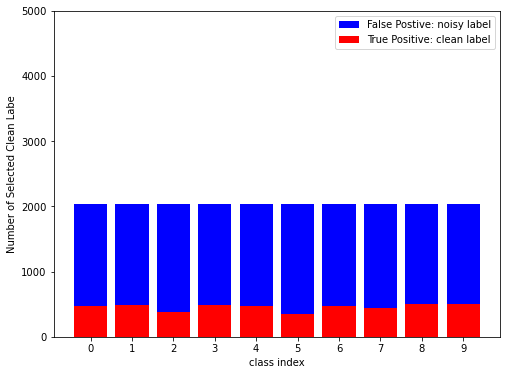

In [268]:
import numpy as np
import matplotlib.pyplot as plt
label = ['0','1','2','3','4','5','6','7','8','9']

plt.figure(figsize=(8,6))
x = np.arange(len(label))
plt.bar(x, NP_classes, color='blue', label='False Postive: noisy label', bottom=TP_classes)
plt.bar(x, TP_classes, color='red', label='True Positive: clean label')

plt.xticks(x, label)
plt.xlabel('class index')
plt.ylabel('Number of Selected Clean Labe')
plt.legend(loc='upper right')
plt.ylim((0,5000))
plt.show()